In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [3]:
! pip install skorch

In [5]:
mnist = fetch_openml('mnist_784', cache=False)

c:\Users\Suleman\anaconda3\envs\DS\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [21]:
mnist.data.shape

(70000, 784)

In [ ]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [ ]:
X /= 255.0

In [24]:
X.min(), X.max()

(0.0, 1.0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [27]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

In [ ]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

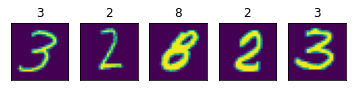

In [29]:
plot_example(X_train, y_train)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [33]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

In [ ]:
from skorch import NeuralNetClassifier

In [ ]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=50,
    lr=0.1,
    device=device,
)

In [39]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8309       0.8865        0.4049  1.2524
      2        0.4323       0.9124        0.3047  1.0754
      3        0.3606       0.9215        0.2682  1.0541
      4        0.3191       0.9297        0.2424  1.0689
      5        0.2969       0.9360        0.2192  1.0807
      6        0.2760       0.9395        0.2040  1.0626
      7        0.2596       0.9440        0.1911  1.1036
      8        0.2463       0.9476        0.1776  1.0839
      9        0.2357       0.9501        0.1697  1.0786
     10        0.2272       0.9521        0.1650  1.0718
     11        0.2198       0.9539        0.1569  1.1598
     12        0.2074       0.9547        0.1536  1.0763
     13        0.2037       0.9558        0.1487  1.0718
     14        0.1985       0.9545        0.1468  1.0772
     15        0.1960       0.9583        0.1392  1.0735
     16        0.1885       0.9

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = net.predict(X_test)

In [42]:
accuracy_score(y_test, y_pred)

0.9693142857142857

In [ ]:
error_mask = y_pred != y_test

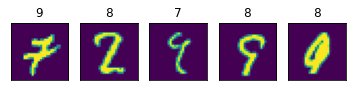

In [44]:
plot_example(X_test[error_mask], y_pred[error_mask])

In [ ]:
XCnn = X.reshape(-1, 1, 28, 28)

In [46]:
XCnn.shape

(70000, 1, 28, 28)

In [ ]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [48]:
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=50,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [51]:
cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.4336       0.9727        0.0897  31.3851
      2        0.1620       0.9791        0.0646  31.1838
      3        0.1252       0.9812        0.0570  31.7659
      4        0.1092       0.9845        0.0504  31.5238
      5        0.0992       0.9853        0.0485  31.5818
      6        0.0925       0.9854        0.0461  31.5155
      7        0.0853       0.9872        0.0414  31.4818
      8        0.0810       0.9876        0.0406  32.7075
      9        0.0807       0.9890        0.0354  32.6055
     10        0.0719       0.9875        0.0397  31.4076
     11        0.0744       0.9870        0.0375  31.5359
     12        0.0698       0.9873        0.0399  31.5913
     13        0.0665       0.9889        0.0368  31.7138
     14        0.0631       0.9899        0.0330  31.5881
     15        0.0609       0.9893        0.0357  31.5433
     16       

In [75]:
import pandas
import pickle
filename = 'finalized_model.sav'
pickle.dump(cnn, open(filename, 'wb'))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cnn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
y_pred_cnn = cnn.predict(XCnn_test)

In [53]:
accuracy_score(y_test, y_pred_cnn)

0.9917714285714285

In [54]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.8063314711359404

Over 70% of the previously misclassified images are now correctly identified.

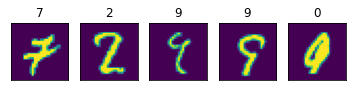

In [55]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])

In [59]:
import os, sys
from PIL import Image
import glob
%matplotlib inline

os.chdir(r'/content/Data')
 
size = 32, 32

for infile in glob.glob("*.jpg"):
    file, ext = os.path.splitext(infile)
    image = Image.open(infile)
    image.thumbnail(size, Image.ANTIALIAS)
    display(image)

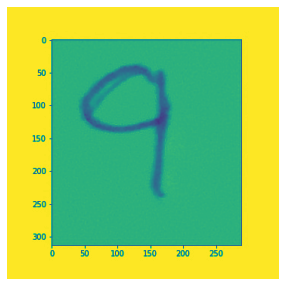

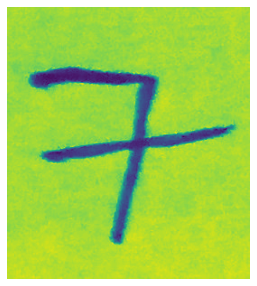

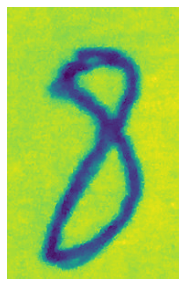

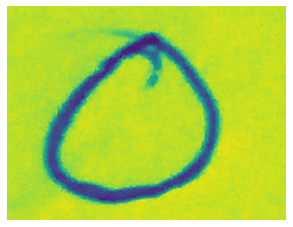

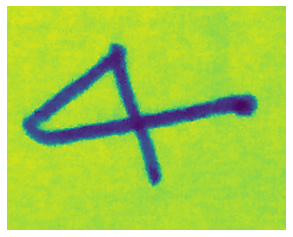

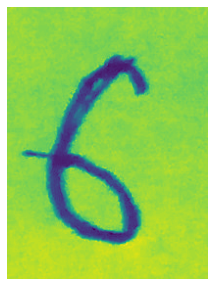

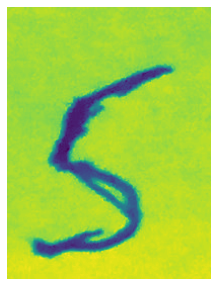

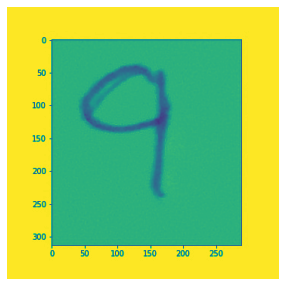

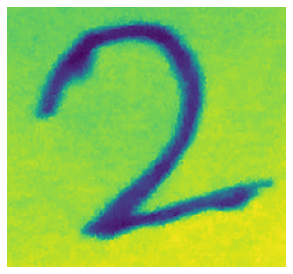

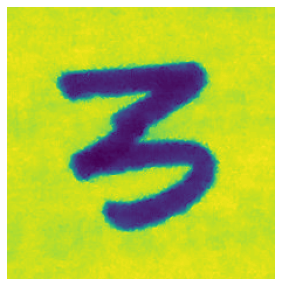

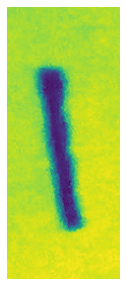

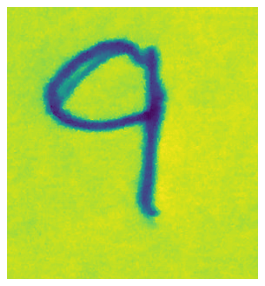

In [68]:
mydir = r'/content/Data'
from skimage import io
import cv2
for fil in glob.glob("*.jpg"):
    image = io.imread(fil) 
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize = (5,5))
    plt.imshow(gray_image)   
    plt.axis('off')
    plt.show()

In [92]:
img = cv2.imread('/content/Gray/0.png', cv2.IMREAD_UNCHANGED)
width = 96
height = 96
dim = (width, height)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
cv2.imwrite("0_1.png",resized)

True

In [ ]:
from keras.preprocessing import image
picturePath = ("/content/Gray/0_1.png")
test_image= image.load_img(picturePath) 
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image) 

In [ ]:
cnn.predict("/content/Gray/0_1.png")  